In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#### Data validation
---
We begin by validating the data. We will check for missing values, duplicates, and outliers. We will also check the data types of the columns and convert them to the appropriate data types. We will also check for any inconsistencies in the data and correct them. Lastly, we will engineer new features from the existing features. 

In [80]:
survey_path = '../data/raw/NARIG_Survey.xlsx'
column_names_path = '../data/processed/json/column_names.json'

survey = pd.read_excel(survey_path, usecols='A:EG')
column_names = pd.read_json(column_names_path, typ='series')

survey.rename(columns=column_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               '6+': 6,
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

ordinal_map = {'Strongly Agree': 5,
               'Agree': 4,
               'Neutral': 3,
               'Disagree': 2,
               'Strongly Disagree': 1}

survey.replace(replace_map, inplace=True)
survey.replace(ordinal_map, inplace=True)

survey['gender'] = survey['gender'].str.split().str[-1]
survey['age'] = survey['age'].replace(0, np.nan)
# survey = survey.astype({'household_size': int})

orig_col_order = list(survey.columns)

value_chains = list(survey['value_chain'].unique())

narig_dfs = {vc: survey[survey['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}


def engineer_change_features(dataframe):
    for col in dataframe.columns:
        if col.endswith('_before') or col.endswith('_after'):
            base_col = col.rsplit('_', 1)[0]
            before_col = base_col + '_before'
            after_col = base_col + '_after'
            if before_col in dataframe.columns and after_col in dataframe.columns:
                change_col = base_col + '_change'
                dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
                change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
                change_col_data = dataframe[change_col]
                dataframe.drop(columns=[change_col], inplace=True)
                dataframe.insert(change_col_index, change_col, change_col_data)
    return dataframe

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    v.dropna(axis=0, inplace=True)
    v = engineer_change_features(v)

narig_dfs['Survey data'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['Survey data'] = narig_dfs['Survey data'][[col for col in orig_col_order if col in narig_dfs['Survey data'].columns]]

narig_dfs['Survey data'] = engineer_change_features(narig_dfs['Survey data'])

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    for col in v.select_dtypes('float').columns:
        if v[col].apply(float.is_integer).all():
            v[col] = v[col].astype(int)
    display(k)
    display(v.info(), v.head().T)

    # v.to_csv('../data/processed/csv/cleaned/{}.csv'.format(k.replace(' ', '_').lower()), index=False)

'Tomato'

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 346
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                53 non-null     category
 1   gender                              53 non-null     category
 2   age                                 53 non-null     int64   
 3   education                           53 non-null     category
 4   monthly_income                      53 non-null     int64   
 5   household_size                      53 non-null     int64   
 6   family_head                         53 non-null     category
 7   value_chain                         53 non-null     category
 8   vc_experience                       53 non-null     int64   
 9   project_skepticism                  53 non-null     int64   
 10  adequate_consultation               53 non-null     int64   
 11  project_acceptance                  53

None

,0,1,2,3,4
ward,Tulimani,Tulimani,Tulimani,Tulimani,Tulimani
gender,Male,Male,Female,Female,Male
age,64,67,33,73,71
education,Secondary,Secondary,Primary,Primary,Secondary
monthly_income,30000,20000,5000,800,10000
...,...,...,...,...,...
farm_productivity_increase,5,5,5,5,5
timely_implementation,4,5,5,4,5
new_income_streams,5,5,5,5,5
job_creation_increase,5,5,5,5,5


'Mango'

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 10 to 362
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                60 non-null     category
 1   gender                              60 non-null     category
 2   age                                 60 non-null     int64   
 3   education                           60 non-null     category
 4   monthly_income                      60 non-null     int64   
 5   household_size                      60 non-null     int64   
 6   family_head                         60 non-null     category
 7   value_chain                         60 non-null     category
 8   vc_experience                       60 non-null     int64   
 9   project_skepticism                  60 non-null     int64   
 10  adequate_consultation               60 non-null     int64   
 11  project_acceptance                  6

None

,10,11,12,13,16
ward,Thange,Thange,Thange,Thange,Thange
gender,Male,Female,Female,Female,Female
age,57,49,67,54,43
education,Primary,Primary,Primary,Primary,Primary
monthly_income,1000,500,500,200,1000
...,...,...,...,...,...
farm_productivity_increase,5,4,4,5,4
timely_implementation,2,3,5,4,4
new_income_streams,3,4,4,5,4
job_creation_increase,4,4,4,5,4


'Green gram'

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 26 to 352
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                62 non-null     category
 1   gender                              62 non-null     category
 2   age                                 62 non-null     int64   
 3   education                           62 non-null     category
 4   monthly_income                      62 non-null     int64   
 5   household_size                      62 non-null     int64   
 6   family_head                         62 non-null     category
 7   value_chain                         62 non-null     category
 8   vc_experience                       62 non-null     int64   
 9   project_skepticism                  62 non-null     int64   
 10  adequate_consultation               62 non-null     int64   
 11  project_acceptance                  6

None

,26,27,29,30,31
ward,Thange,Thange,Thange,Thange,Thange
gender,Female,Male,Female,Male,Male
age,60,70,60,63,70
education,Primary,Primary,Primary,Secondary,Secondary
monthly_income,1000,500,1000,3000,12000
...,...,...,...,...,...
farm_productivity_increase,3,5,5,5,5
timely_implementation,4,4,4,4,4
new_income_streams,4,4,5,4,4
job_creation_increase,5,4,4,4,4


'Indigenous chicken'

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 46 to 337
Data columns (total 62 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                161 non-null    category
 1   gender                              161 non-null    category
 2   age                                 161 non-null    int64   
 3   education                           161 non-null    category
 4   monthly_income                      161 non-null    int64   
 5   household_size                      161 non-null    int64   
 6   family_head                         161 non-null    category
 7   value_chain                         161 non-null    category
 8   vc_experience                       161 non-null    int64   
 9   project_skepticism                  161 non-null    int64   
 10  adequate_consultation               161 non-null    int64   
 11  project_acceptance                  

None

,46,47,48,49,50
ward,Tulimani,Tulimani,Tulimani,Tulimani,Tulimani
gender,Male,Male,Male,Male,Female
age,68,74,80,74,71
education,Primary,Primary,Secondary,Primary,Primary
monthly_income,400,1500,2500,2000,2000
...,...,...,...,...,...
farm_productivity_increase,5,5,5,5,5
timely_implementation,5,5,5,5,5
new_income_streams,5,5,5,5,5
job_creation_increase,5,5,5,5,5


'Survey data'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                336 non-null    category
 1   gender                              336 non-null    category
 2   age                                 336 non-null    int64   
 3   education                           336 non-null    category
 4   monthly_income                      336 non-null    int64   
 5   household_size                      336 non-null    int64   
 6   family_head                         336 non-null    category
 7   value_chain                         336 non-null    category
 8   vc_experience                       336 non-null    int64   
 9   project_skepticism                  336 non-null    int64   
 10  adequate_consultation               336 non-null    int64   
 11  project_acceptance              

None

,0,1,2,3,4
ward,Tulimani,Tulimani,Tulimani,Tulimani,Tulimani
gender,Male,Male,Female,Female,Male
age,64,67,33,73,71
education,Secondary,Secondary,Primary,Primary,Secondary
monthly_income,30000,20000,5000,800,10000
...,...,...,...,...,...
farm_productivity_increase,5,5,5,5,5
timely_implementation,4,5,5,4,5
new_income_streams,5,5,5,5,5
job_creation_increase,5,5,5,5,5


In [81]:
perf = narig_dfs['Survey data'].iloc[:, 27:]

performance = narig_dfs['Survey data'].iloc[:, -6:]

perf = perf.loc[:, ~perf.columns.str.contains('trained|before|after')].dropna(axis=1, thresh=273)

perf = pd.get_dummies(perf, columns=perf.select_dtypes('category').columns, drop_first=True)

performance

,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
0,5,5,4,5,5,5
1,5,5,5,5,5,5
2,5,5,5,5,5,5
3,5,5,4,5,5,5
4,5,5,5,5,5,5
...,...,...,...,...,...,...
331,4,4,4,4,4,4
332,4,4,4,4,4,4
333,4,4,4,4,4,4
334,5,5,5,5,5,5


In [82]:
def create_composite_feature(data, variables, method='mean', weights=None):
    """
    Create a composite feature from a set of variables.
    
    Parameters
    ----------
    data : pandas.DataFrame
        The dataframe containing the variables.
    variables : list
        The list of variables to combine.
    method : str, optional
        The method to use to combine the variables ('mean', 'sum', 'weighted_mean', 'weighted_sum', 'interaction', 'pca').
    weights : list, optional
        The list of weights to use for the variables. The default is None (only used for 'weighted_mean' and 'weighted_sum').
        
    Returns
    -------
    data : pandas.DataFrame
        The dataframe with the new composite feature.
        
    Examples
    --------
    >>> data = create_composite_feature(data, ['var1', 'var2', 'var3'], method='weighted_mean', weights=[0.5, 0.3, 0.2])
    >>> data = create_composite_feature(data, ['var1', 'var2', 'var3'], method='pca')
    >>> data = create_composite_feature(data, ['var1', 'var2', 'var3'], method='interaction')
    >>> data = create_composite_feature(data, ['var1', 'var2', 'var3'], method='sum')
    """
    
    # Import library to create a composite feature
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Create a composite feature
    if method == 'mean':
        data['composite'] = data[variables].mean(axis=1)
    elif method == 'sum':
        data[f'composite ({method})'] = data[variables].sum(axis=1)
    elif method == 'weighted_mean':
        data[f'composite ({method})'] = np.average(data[variables], axis=1, weights=weights)
    elif method == 'weighted_sum':
        data[f'composite ({method})'] = np.dot(data[variables], weights)
    elif method == 'interaction':
        data[f'composite ({method})'] = data[variables].prod(axis=1)
    elif method == 'pca':
        # Standardize the data
        data[variables] = StandardScaler().fit_transform(data[variables])
        
        # Create a PCA object
        pca = PCA(n_components=1)
        
        # Fit the PCA object
        data[f'composite ({method})'] = pca.fit_transform(data[variables])
    else:
        raise ValueError('Invalid method.')
    
    return data

# For each method, create a composite feature
composite_feature_mean = create_composite_feature(performance, performance.columns.tolist())
composite_feature_sum = create_composite_feature(performance, performance.columns.tolist(), method='sum')
composite_feature_interaction = create_composite_feature(performance, performance.columns.tolist(), method='interaction')
composite_feature_pca = create_composite_feature(performance, performance.columns.tolist(), method='pca')

In [85]:
composite_feature_mean

,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity,composite,composite (sum),composite (interaction),composite (pca)
0,0.884612,1.006221,-0.651835,1.085931,1.073831,0.972758,0.900272,0.900272,0.726107,-2.339212
1,0.884612,1.006221,1.128787,1.085931,1.073831,0.972758,1.264719,1.264719,1.425523,-3.391208
2,0.884612,1.006221,1.128787,1.085931,1.073831,0.972758,1.264719,1.264719,1.425523,-3.391208
3,0.884612,1.006221,-0.651835,1.085931,1.073831,0.972758,0.900272,0.900272,0.726107,-2.339212
4,0.884612,1.006221,1.128787,1.085931,1.073831,0.972758,1.264719,1.264719,1.425523,-3.391208
...,...,...,...,...,...,...,...,...,...,...
331,-0.804193,-0.675820,-0.651835,-0.738433,-0.795636,-0.813289,-0.921965,-0.921965,-0.880228,2.410921
332,-0.804193,-0.675820,-0.651835,-0.738433,-0.795636,-0.813289,-0.921965,-0.921965,-0.880228,2.410921
333,-0.804193,-0.675820,-0.651835,-0.738433,-0.795636,-0.813289,-0.921965,-0.921965,-0.880228,2.410921
334,0.884612,1.006221,1.128787,1.085931,1.073831,0.972758,1.264719,1.264719,1.425523,-3.391208


In [67]:
# sns.pairplot(data=composite_feature_mean, y_vars='composite')
# plt.show()
# 
# fig, ax = plt.subplots(1, 4, figsize=(12, 3))
# 
# sns.histplot(composite_feature_mean['composite'], kde=True)
# plt.title('Distribution of the mean composite feature')
# plt.show()

In [68]:
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths=None, fontext='otf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'Sono'
# plt.rcParams['font.family'] = 'DM Mono'
# plt.rcParams['font.family'] = 'Space Mono'mp;kf Libre'
font_size = 10
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['legend.fontsize'] = font_size
plt.rcParams['figure.titlesize'] = font_size
plt.rcParams['axes.titlesize'] = font_size  + 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['grid.alpha'] = 0.2
# plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['figure.constrained_layout.use'] = True

In [69]:
# plt.style.available
# plt.rcParams.update(plt.rcParamsDefault)

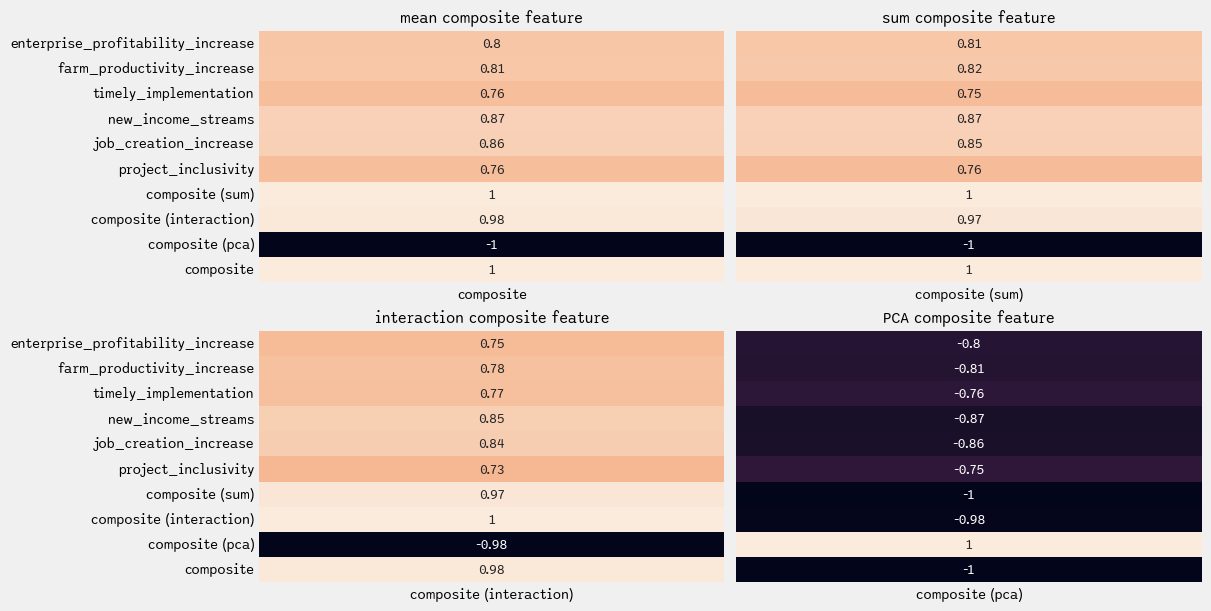

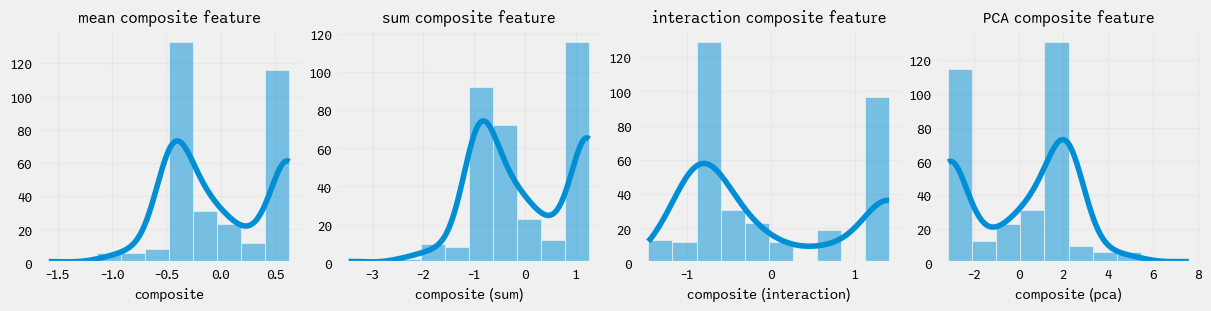

C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


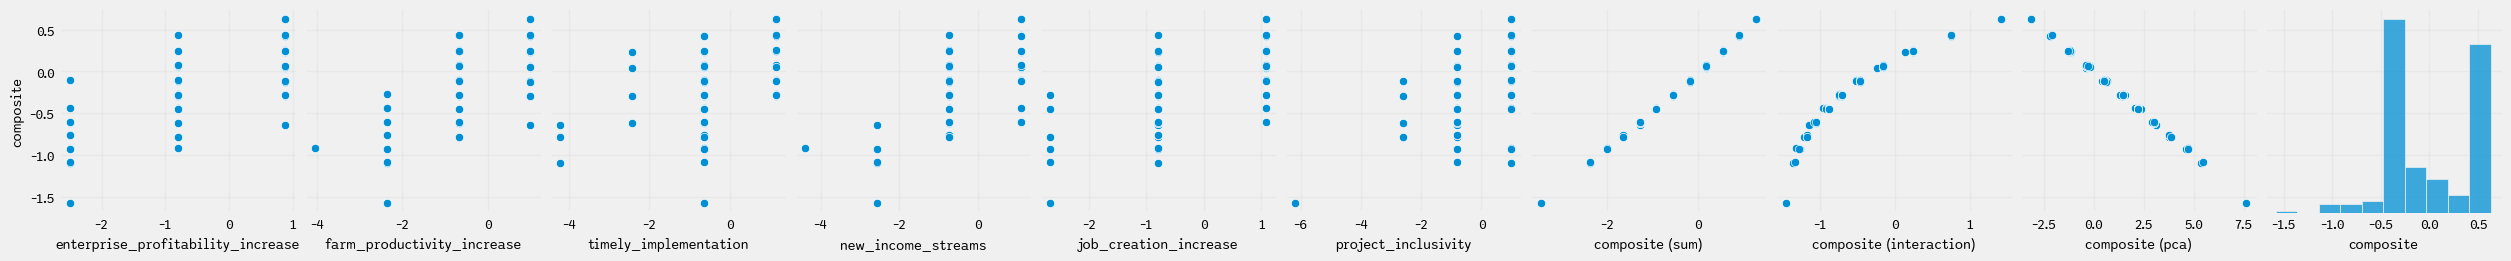

In [70]:
# Plot correlation of composite features and the original features
fig, ax = plt.subplots(2,2, figsize=(12, 6), sharex=False, sharey=True)

# Plot the correlation of the mean composite feature and the original features
sns.heatmap(composite_feature_mean.corr()[['composite']], annot=True, ax=ax[0,0], cbar=False)
ax[0,0].set_title('mean composite feature')

# Plot the correlation of the sum composite feature and the original features
sns.heatmap(composite_feature_sum.corr()[['composite (sum)']], annot=True, ax=ax[0,1], cbar=False)
ax[0,1].set_title('sum composite feature')

# Plot the correlation of the interaction composite feature and the original features
sns.heatmap(composite_feature_interaction.corr()[['composite (interaction)']], annot=True, ax=ax[1,0], cbar=False)
ax[1,0].set_title('interaction composite feature')

# Plot the correlation of the PCA composite feature and the original features
sns.heatmap(composite_feature_pca.corr()[['composite (pca)']], annot=True, ax=ax[1,1], cbar=False)
ax[1,1].set_title('PCA composite feature')

# Show the figure
plt.show()

# fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=True)
# 
# sns.barplot(y=composite_feature_mean.columns, x=composite_feature_mean.iloc[0], ax=ax[0,0])
# ax[0,0].set_title('mean composite feature')
# ax[0,0].set_xlabel('')
# ax[0,0].set_ylabel('')
# 
# sns.barplot(y=composite_feature_sum.columns, x=composite_feature_sum.iloc[0], ax=ax[0,1])
# ax[0,1].set_title('sum composite feature')
# ax[0,1].set_xlabel('')
# ax[0,1].set_ylabel('')
# 
# sns.barplot(y=composite_feature_interaction.columns, x=composite_feature_interaction.iloc[0], ax=ax[1,0])
# ax[1,0].set_title('interaction composite feature')
# ax[1,0].set_xlabel('')
# ax[1,0].set_ylabel('')
# 
# sns.barplot(y=composite_feature_pca.columns, x=composite_feature_pca.iloc[0], ax=ax[1,1])
# ax[1,1].set_title('PCA composite feature')
# ax[1,1].set_xlabel('')
# ax[1,1].set_ylabel('')
# 
# plt.show()

# Plot the distributions of the composite features on one figure
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(composite_feature_mean['composite'], kde=True, ax=ax[0])
ax[0].set_title('mean composite feature')
ax[0].set_ylabel('')

sns.histplot(composite_feature_sum['composite (sum)'], kde=True, ax=ax[1])
ax[1].set_title('sum composite feature')
ax[1].set_ylabel('')

sns.histplot(composite_feature_interaction['composite (interaction)'], kde=True, ax=ax[2])
ax[2].set_title('interaction composite feature')
ax[2].set_ylabel('')

sns.histplot(composite_feature_pca['composite (pca)'], kde=True, ax=ax[3])
ax[3].set_title('PCA composite feature')
ax[3].set_ylabel('')

plt.show()
 
sns.pairplot(data=composite_feature_mean, y_vars='composite')
plt.show()    paim

In [ ]:
def create_index(dataframe: pd.DataFrame, columns: list):
    # Import library to create a composite index
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposi, cbar=Falsetion import PCA
    
    # Create a composite index
    index = dataframe[columns]
    
    # Standardize the data
    index = StandardScaler().fit_transform(index)
    
    # Create a PCA object
    pca = PCA(n_components=1)
    
    # Fit the PCA object
    index = pca.fit_transform(index)
    
    # Create a dataframe from the PCA object
    index = pd.DataFrame(index, columns=['index'])
    
    # Add the index to the dataframe
    dataframe = pd.concat([dataframe, index], axis=1)
    
    # Create a figure
    fig, ax = plt.subplots(2,1, figsize=(10, 10))
    
    # Plot the overall variance explained by the index
    sns.barplot(x=np.arange(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_, ax=ax[0])
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    plt.title('Explained variance by number of components')
    
    # Plot the loadings of the index
    sns.barplot(x=columns, y=pca.components_[0], ax=ax[1])
    plt.xlabel('Number of components')
    plt.ylabel('Loadings')
    plt.title('Loadings of the index')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    
    # Show the figure
    plt.show()
    
    return dataframe

perff = create_index(perf, perf.columns.tolist())

display(perff.info(), perff.head().T)

In [ ]:
# Plot the distributions of the perff

In [ ]:
for col in perff.columns:
    # Display the distribution of the data
    sns.disp,;p0    `(''
                      '][lot(perff[col], kde=False))
    # Add lines for the mean, median, and mode
    plt.axvline(perff[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(perff[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    plt.axvline(perff[col].mode()[0], color='yellow', linestyle='dashed', linewidth=2)
    # Label the figure
    plt.title('Distribution of {}'.format(col))
    plt.legend({'Mean':perff[col].mean(),'Median':perff[col].median(),'Mode':perff[col].mode()[0]})
    plt.show()

In [ ]:
# Plot the distributions of the perff
# Log transform the data
perff = np.sqrt(perff)

sns.pairplot(perff, diag_kind='kde')
plt.show()